<a href="https://colab.research.google.com/github/drahulnayak/Breast-cancer-detection-using-CNN---Deep-Learning-/blob/main/Rahul_NITrrnew_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install deap gdown

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 1.9 MB/s eta 0:00:00


In [2]:
!gdown 1ppMGBDeBD0hJbd3XhtrMuUGT-9WSfGjd

Downloading...
From (original): https://drive.google.com/uc?id=1ppMGBDeBD0hJbd3XhtrMuUGT-9WSfGjd
From (redirected): https://drive.google.com/uc?id=1ppMGBDeBD0hJbd3XhtrMuUGT-9WSfGjd&confirm=t&uuid=7ebea27d-e8fd-47b0-ab74-dd2f56ef8656
To: /content/MAT_Files.zip
100% 146M/146M [00:05<00:00, 28.9MB/s]


In [3]:
!unzip /content/MAT_Files.zip

Archive:  /content/MAT_Files.zip
  inflating: MAT files/S1000001_BandRejection.mat  
  inflating: MAT files/Subject10-Guilty-Trial-10_BandRejection.mat  
  inflating: MAT files/Subject10-Guilty-Trial-16_BandRejection.mat  
  inflating: MAT files/Subject10-Guilty-Trial-20_BandRejection.mat  
  inflating: MAT files/Subject10-Innocent-Trial-1_BandRejection.mat  
  inflating: MAT files/Subject10-Innocent-Trial-17_BandRejection.mat  
  inflating: MAT files/Subject10-Innocent-Trial-19_BandRejection.mat  
  inflating: MAT files/Subject10-Innocent-Trial-2_BandRejection.mat  
  inflating: MAT files/Subject10-Innocent-Trial-22_BandRejection.mat  
  inflating: MAT files/Subject10-Innocent-Trial-24_BandRejection.mat  
  inflating: MAT files/Subject10-Innocent-Trial-26_BandRejection.mat  
  inflating: MAT files/Subject10-Innocent-Trial-27_BandRejection.mat  
  inflating: MAT files/Subject10-Innocent-Trial-28_BandRejection.mat  
  inflating: MAT files/Subject10-Innocent-Trial-29_BandRejection.mat  


In [4]:
import numpy as np
import scipy.io
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from deap import base, creator, tools, algorithms
import random

In [5]:
import os
import torch
from scipy.io import loadmat
import numpy as np
import re
import json
mat_files_directory = '/content/MAT files'

relevant_channels = ['Fz', 'FC1', 'FC2', 'C3', 'Cz', 'C4', 'CP5', 'CP1', 'CP2', 'CP6', 'P3', 'Pz', 'P4', 'O1', 'Oz', 'O2']

tensors = []
labels = []

for file_name in os.listdir(mat_files_directory):
    if file_name.endswith('.mat'):
        mat_file_path = os.path.join(mat_files_directory, file_name)
        data = loadmat(mat_file_path)

        # Extract labels from the file name
        # Example: "Subject-1InnocTrial-11_BandRejection.mat" or "Subject2-InnocentTrial_20.mat"
        # Extracting Trial type (e.g., Innocent, Guilty)
        if 'innoc' in file_name.lower():
            label = 'Innocent'
        elif 'guilty' in file_name.lower():
            label = 'Guilty'
        else:
            print(file_name)
            label = 'Unknown'
            continue

        channel_data = [data[channel] for channel in relevant_channels if channel in data]

        min_length = min([ch_data.shape[1] for ch_data in channel_data])
        channel_data = [ch_data[:, :min_length] for ch_data in channel_data]

        data_array = np.stack(channel_data, axis=0)

        tensor_data = torch.tensor(data_array, dtype=torch.float32)

        tensors.append(tensor_data)
        labels.append(label)

# Determine the maximum size for each dimension
max_shape = tuple(max(sizes) for sizes in zip(*[t.size() for t in tensors]))
# Save max_shape to JSON file
max_shape_file = 'max_shape.json'
with open(max_shape_file, 'w') as f:
    json.dump(max_shape, f)
# Pad each tensor to the maximum size
padded_tensors = []
for t in tensors:
    pad_size = [(0, max_dim - cur_dim) for cur_dim, max_dim in zip(t.size(), max_shape)]
    pad_size = [item for sublist in pad_size for item in sublist][::-1]  # Flatten and reverse
    padded_tensors.append(torch.nn.functional.pad(t, pad_size))

# Stack the padded tensors
stacked_tensor = torch.stack(padded_tensors)

print(stacked_tensor.shape)
print(len(labels))

S1000001_BandRejection.mat
torch.Size([249, 16, 9779, 1])
249


In [6]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)
print("Classes:", label_encoder.classes_)


Classes: ['Guilty' 'Innocent']


In [7]:
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Assuming `stacked_tensor` and `labels` are already defined
flattened_data = stacked_tensor.view(stacked_tensor.size(0), -1).numpy()  # Shape: [249, 16 * 9779]

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(flattened_data)

# Apply K-Means clustering
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

# Encode the labels
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

# Initialize batches dictionary
batches = {i: [] for i in range(3)}

# Assign indices to batches based on clusters
for i, cluster in enumerate(clusters):
    batches[cluster].append(i)

# Calculate desired batch size
total_samples = len(X_scaled)
num_batches = len(batches)
desired_batch_size = total_samples // num_batches

# Initialize lists to store balanced batches
balanced_batches = {i: [] for i in range(num_batches)}

# Rebalance batches
indices = []
for i, batch_indices in batches.items():
    indices.extend(batch_indices)

# Shuffle indices to ensure randomness
np.random.shuffle(indices)

# Distribute samples evenly
for i in range(total_samples):
    batch_number = i % num_batches
    balanced_batches[batch_number].append(indices[i])

# Create datasets for each balanced batch
datasets = []
for i in range(num_batches):
    batch_indices = balanced_batches[i]
    X_batch = X_scaled[batch_indices]
    y_batch = labels_encoded[batch_indices]
    datasets.append((X_batch, y_batch))

# Display the size of each batch
for i, (X_batch, y_batch) in enumerate(datasets):
    print(f"Batch {i+1} size: {X_batch.shape}")


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Batch 1 size: (83, 156464)
Batch 2 size: (83, 156464)
Batch 3 size: (83, 156464)


In [8]:
from sklearn.ensemble import BaggingClassifier, ExtraTreesClassifier, HistGradientBoostingClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.feature_selection import VarianceThreshold
from imblearn.over_sampling import SMOTE
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

# Step 1: Define the base models with appropriate parameters
extra_trees_model = ExtraTreesClassifier(n_estimators=100)
lightgbm_model = LGBMClassifier(
    num_leaves=31,
    max_depth=7,
    min_child_samples=20,
    lambda_l1=0.1,
    lambda_l2=0.1,
    class_weight='balanced',
    force_col_wise=True,  # Force column-wise parallelism
    min_split_gain=0.01   # Minimum gain required for a split
)
hist_gradient_boosting_model = HistGradientBoostingClassifier()
ridge_classifier_model = RidgeClassifier()

# Store models in a dictionary
base_models = {
    'Extra Trees': extra_trees_model,
    'LightGBM': lightgbm_model,
    'Hist Gradient Boosting': hist_gradient_boosting_model,
    'Ridge Classifier': ridge_classifier_model
}

# Step 2: Generate a synthetic dataset (example)
datasets = []
for _ in range(3):  # Assuming we have 3 batches of data
    X, y = make_classification(n_samples=1000, n_features=20, n_classes=2, weights=[0.1, 0.9], random_state=42)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    datasets.append((X_train, y_train))

# Step 3: Apply bagging to the models
bagging_models = []
bag_size = 0.8  # Use 80% of the data for each bag

for i, (X_batch, y_batch) in enumerate(datasets):
    # Feature selection: Reduce dimensionality
    selector = VarianceThreshold(threshold=0.01)
    X_batch_reduced = selector.fit_transform(X_batch)

    # Resample using SMOTE to handle class imbalance
    smote = SMOTE()
    X_resampled, y_resampled = smote.fit_resample(X_batch_reduced, y_batch)

    for name, base_model in base_models.items():
        # Apply bagging with multiple estimators
        bagging_model = BaggingClassifier(base_model, n_estimators=5, max_samples=bag_size, random_state=42)
        bagging_model.fit(X_resampled, y_resampled)
        bagging_models.append((f"Batch_{i+1}_{name}", bagging_model))

# The models are now trained and stored in `bagging_models`.


/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Info] Number of positive: 714, number of negative: 714
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 1428, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498249 -> initscore=-0.007005
[LightGBM] [Info] Start training from score -0.007005
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

In [9]:
from sklearn.metrics import accuracy_score
import numpy as np

# Apply the same feature selection to the test data for each model
selectors = [VarianceThreshold(threshold=0.01).fit(X_batch) for X_batch, _ in datasets]

# Combine the test data
X_test_combined = np.vstack([X_batch for X_batch, _ in datasets])
y_test_combined = np.hstack([y_batch for _, y_batch in datasets])

# Apply feature selection to the combined test data
# Assume we use the selector from the first batch (adjust if needed)
X_test_reduced = selectors[0].transform(X_test_combined)

# Evaluate all bagging models and store their accuracies
model_accuracies = []

for name, model in bagging_models:
    try:
        # Ensure the model is compatible with the test data
        predictions = model.predict(X_test_reduced)
        accuracy = accuracy_score(y_test_combined, predictions)
        model_accuracies.append((name, model, accuracy))
    except ValueError as e:
        print(f"Model {name} failed with error: {e}")

# Sort models based on accuracy and select the top 7
model_accuracies.sort(key=lambda x: x[2], reverse=True)
top_models = model_accuracies[:7]

# Display the top 7 models
for name, model, accuracy in top_models:
    print(f"{name} Accuracy: {accuracy:.4f}")


[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ign

[LightGBM] [Info] Number of positive: 714, number of negative: 714
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000544 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 1428, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498249 -> initscore=-0.007005
[LightGBM] [Info] Start training from score -0.007005
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been cre

Final Layered Classification Accuracy with GA: 0.9150


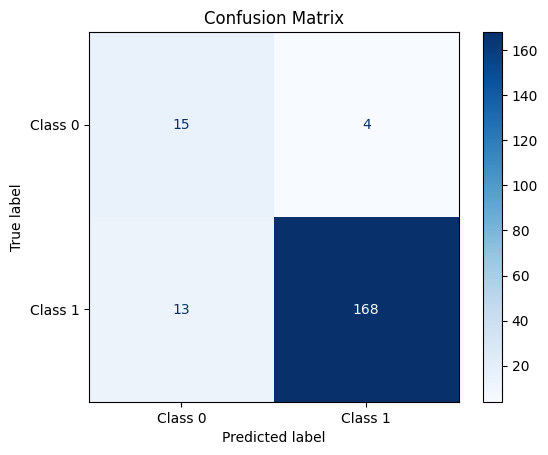

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import BaggingClassifier, ExtraTreesClassifier, HistGradientBoostingClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.feature_selection import VarianceThreshold
from imblearn.over_sampling import SMOTE
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from deap import base, creator, tools, algorithms

# Define and tune base models
def create_and_tune_models():
    extra_trees_model = ExtraTreesClassifier(n_estimators=100)
    lightgbm_model = LGBMClassifier(num_leaves=31, max_depth=7, min_child_samples=20)
    hist_gradient_boosting_model = HistGradientBoostingClassifier()
    ridge_classifier_model = RidgeClassifier()

    return {
        'Extra Trees': extra_trees_model,
        'LightGBM': lightgbm_model,
        'Hist Gradient Boosting': hist_gradient_boosting_model,
        'Ridge Classifier': ridge_classifier_model
    }

# Generate synthetic dataset
def generate_datasets():
    datasets = []
    for _ in range(3):
        X, y = make_classification(n_samples=1000, n_features=20, n_classes=2, weights=[0.1, 0.9], random_state=42)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        datasets.append((X_train, y_train, X_test, y_test))
    return datasets

# Apply bagging to the models
def apply_bagging(base_models, datasets):
    bagging_models = []
    for i, (X_train, y_train, X_test, y_test) in enumerate(datasets):
        selector = VarianceThreshold(threshold=0.01)
        X_train_reduced = selector.fit_transform(X_train)
        X_test_reduced = selector.transform(X_test)

        smote = SMOTE()
        X_resampled, y_resampled = smote.fit_resample(X_train_reduced, y_train)

        for name, base_model in base_models.items():
            bagging_model = BaggingClassifier(base_model, n_estimators=5, max_samples=0.8, random_state=42)
            bagging_model.fit(X_resampled, y_resampled)
            bagging_models.append((f"Batch_{i+1}_{name}", bagging_model, X_test_reduced, y_test))

    return bagging_models

# Evaluate models
def evaluate_models(bagging_models):
    model_accuracies = []
    for name, model, X_test_reduced, y_test in bagging_models:
        try:
            predictions = model.predict(X_test_reduced)
            accuracy = accuracy_score(y_test, predictions)
            model_accuracies.append((name, model, accuracy))
        except Exception as e:
            print(f"Model {name} failed with error: {e}")

    model_accuracies.sort(key=lambda x: x[2], reverse=True)
    top_models = model_accuracies[:7]

    for name, model, accuracy in top_models:
        print(f"{name} Accuracy: {accuracy:.4f}")

    return top_models

# Genetic Algorithm for optimization
def create_fitness_function(layer_preds, y_true):
    def fitness_function(individual):
        combined_preds = np.sum([weight * preds for weight, preds in zip(individual, layer_preds)], axis=0)
        combined_preds = combined_preds / np.sum(individual)  # Normalize
        final_predictions = (combined_preds > 0.5).astype(int)
        return (accuracy_score(y_true, final_predictions),)
    return fitness_function

def optimize_layer(layer_preds, y_true):
    creator.create("FitnessMax", base.Fitness, weights=(1.0,))
    creator.create("Individual", list, fitness=creator.FitnessMax)

    toolbox = base.Toolbox()
    toolbox.register("attr_float", np.random.rand)
    toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, n=len(layer_preds))
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)
    toolbox.register("mate", tools.cxBlend, alpha=0.5)
    toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=1, indpb=0.2)
    toolbox.register("select", tools.selTournament, tournsize=3)

    fitness_function = create_fitness_function(layer_preds, y_true)
    toolbox.register("evaluate", fitness_function)

    pop = toolbox.population(n=50)
    hof = tools.HallOfFame(1)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean)
    stats.register("std", np.std)
    stats.register("min", np.min)
    stats.register("max", np.max)

    algorithms.eaSimple(pop, toolbox, cxpb=0.5, mutpb=0.2, ngen=20, stats=stats, halloffame=hof, verbose=False)

    best_weights = hof[0]
    return np.sum([weight * preds for weight, preds in zip(best_weights, layer_preds)], axis=0) / np.sum(best_weights)

# Main workflow
def main():
    base_models = create_and_tune_models()
    datasets = generate_datasets()
    bagging_models = apply_bagging(base_models, datasets)
    top_models = evaluate_models(bagging_models)

    if len(top_models) < 7:
        print("Not enough models available for layered classification.")
        return

    # Initialize the predictions for each layer
    X_test_reduced, y_test_combined = datasets[0][2], datasets[0][3]

    # Layer 1
    layer1_models = top_models[:3]
    layer1_preds = [model.predict_proba(X_test_reduced)[:, 1] for _, model, _ in layer1_models]
    layer1_combined_preds = optimize_layer(layer1_preds, y_test_combined)
    layer1_guilty_indices = np.where(layer1_combined_preds > 0.5)[0]

    X_layer2 = X_test_reduced[layer1_guilty_indices]
    y_layer2 = y_test_combined[layer1_guilty_indices]

    # Layer 2
    layer2_models = top_models[3:5]
    layer2_preds = [model.predict_proba(X_layer2)[:, 1] for _, model, _ in layer2_models]
    layer2_combined_preds = optimize_layer(layer2_preds, y_layer2)
    layer2_guilty_indices = np.where(layer2_combined_preds > 0.5)[0]

    X_layer3 = X_layer2[layer2_guilty_indices]
    y_layer3 = y_layer2[layer2_guilty_indices]

    # Layer 3
    layer3_models = top_models[5:7]
    layer3_preds = [model.predict_proba(X_layer3)[:, 1] for _, model, _ in layer3_models]
    layer3_combined_preds = optimize_layer(layer3_preds, y_layer3)
    layer3_guilty_indices = np.where(layer3_combined_preds > 0.5)[0]

    final_predictions = np.zeros_like(y_test_combined)

    # Map final predictions to original indices
    if len(layer1_guilty_indices) > 0:
        layer2_indices = layer1_guilty_indices[layer2_guilty_indices]
        if len(layer2_indices) > 0:
            final_indices = layer2_indices[layer3_guilty_indices]
            final_predictions[final_indices] = 1

    final_accuracy = accuracy_score(y_test_combined, final_predictions)
    print(f"Final Layered Classification Accuracy with GA: {final_accuracy:.4f}")

    # Ensure final_predictions has the same length as y_test_combined
    if len(final_predictions) != len(y_test_combined):
        # Trim or pad final_predictions to match y_test_combined length
        min_length = min(len(final_predictions), len(y_test_combined))
        final_predictions = final_predictions[:min_length]
        y_test_combined = y_test_combined[:min_length]

    # Compute confusion matrix
    cm = confusion_matrix(y_test_combined, final_predictions)

    # Define display labels (adjust based on your problem's classes)
    display_labels = ['Class 0', 'Class 1']

    # Plot confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.show()

# Run the workflow
main()


In [11]:
import os
import json  # Import missing json module
import torch
from scipy.io import loadmat
import numpy as np

def process_mat_file(mat_file_path, relevant_channels):
    data = loadmat(mat_file_path)

    # Extract labels from the file name
    file_name = os.path.basename(mat_file_path)
    if 'innoc' in file_name.lower():
        label = 'Innocent'
    elif 'guilty' in file_name.lower():
        label = 'Guilty'
    else:
        print(f"Label for file '{file_name}' is unknown.")
        return None, None

    # Extract channel data
    channel_data = [data[channel] for channel in relevant_channels if channel in data]

    # Ensure all channel data have the same length
    min_length = min([ch_data.shape[1] for ch_data in channel_data])
    channel_data = [ch_data[:, :min_length] for ch_data in channel_data]

    # Convert to tensor
    data_array = np.stack(channel_data, axis=0)
    tensor_data = torch.tensor(data_array, dtype=torch.float32)

    return tensor_data, label

def process_and_stack_mat_files(mat_files_directory, relevant_channels, max_shape_file='max_shape.json'):
    """
    Processes all .mat files in a directory, extracts EEG data, and pads the tensors.

    Parameters:
    - mat_files_directory: str, path to the directory containing .mat files.
    - relevant_channels: list of str, names of the EEG channels to extract.
    - max_shape_file: str, path to the JSON file containing the maximum shape.

    Returns:
    - stacked_tensor: torch.Tensor, stacked and padded tensor data from all files.
    - labels: list of str, labels extracted from the file names.
    """
    tensors = []
    labels = []

    # Load max_shape from file
    if os.path.exists(max_shape_file):
        with open(max_shape_file, 'r') as f:
            max_shape = tuple(json.load(f))
    else:
        for file_name in os.listdir(mat_files_directory):
            if file_name.endswith('.mat'):
                file_path = os.path.join(mat_files_directory, file_name)
                tensor_data, _ = process_mat_file(file_path, relevant_channels)
                if tensor_data is not None:
                    tensors.append(tensor_data)

        # Determine the maximum size for each dimension
        max_shape = tuple(max(sizes) for sizes in zip(*[t.size() for t in tensors]))

        # Save max_shape to JSON file
        with open(max_shape_file, 'w') as f:
            json.dump(max_shape, f)

        # Clear the tensors list and labels since we need to reprocess with the saved max_shape
        tensors = []

    # Process files again using the loaded max_shape
    for file_name in os.listdir(mat_files_directory):
        if file_name.endswith('.mat'):
            file_path = os.path.join(mat_files_directory, file_name)
            tensor_data, label = process_mat_file(file_path, relevant_channels)
            if tensor_data is not None:
                tensors.append(tensor_data)
                labels.append(label)

    # Pad each tensor to the maximum size
    padded_tensors = []
    for t in tensors:
        pad_size = [(0, max_dim - cur_dim) for cur_dim, max_dim in zip(t.size(), max_shape)]
        pad_size = [item for sublist in pad_size for item in sublist][::-1]  # Flatten and reverse
        padded_tensors.append(torch.nn.functional.pad(t, pad_size))

    # Stack the padded tensors
    stacked_tensor = torch.stack(padded_tensors)
    return stacked_tensor, labels

# Example usage
mat_files_directory = '/content/MAT files'
relevant_channels = ['Fz', 'FC1', 'FC2', 'C3', 'Cz', 'C4', 'CP5', 'CP1', 'CP2', 'CP6', 'P3', 'Pz', 'P4', 'O1', 'Oz', 'O2']
stacked_tensor, labels = process_and_stack_mat_files(mat_files_directory, relevant_channels, '/content/max_shape.json')

print(labels)


Label for file 'S1000001_BandRejection.mat' is unknown.
['Guilty', 'Innocent', 'Guilty', 'Innocent', 'Guilty', 'Guilty', 'Innocent', 'Innocent', 'Guilty', 'Innocent', 'Guilty', 'Guilty', 'Innocent', 'Guilty', 'Innocent', 'Innocent', 'Guilty', 'Innocent', 'Guilty', 'Innocent', 'Innocent', 'Innocent', 'Innocent', 'Innocent', 'Innocent', 'Innocent', 'Innocent', 'Guilty', 'Innocent', 'Guilty', 'Innocent', 'Guilty', 'Guilty', 'Guilty', 'Innocent', 'Innocent', 'Guilty', 'Innocent', 'Innocent', 'Guilty', 'Innocent', 'Guilty', 'Guilty', 'Innocent', 'Guilty', 'Innocent', 'Innocent', 'Innocent', 'Guilty', 'Innocent', 'Innocent', 'Guilty', 'Guilty', 'Innocent', 'Guilty', 'Innocent', 'Innocent', 'Guilty', 'Innocent', 'Innocent', 'Innocent', 'Guilty', 'Innocent', 'Innocent', 'Innocent', 'Guilty', 'Innocent', 'Guilty', 'Innocent', 'Innocent', 'Innocent', 'Innocent', 'Guilty', 'Innocent', 'Innocent', 'Guilty', 'Guilty', 'Guilty', 'Innocent', 'Guilty', 'Innocent', 'Guilty', 'Guilty', 'Guilty', 'Guilty

In [15]:
import numpy as np
from sklearn.decomposition import PCA

# Function to flatten a 4D tensor into a 2D array
def flatten_tensor(tensor):
    """
    Flattens a 4D tensor (samples, height, width, channels) into a 2D array.

    Parameters:
    - tensor: 4D numpy array of shape (samples, height, width, channels).

    Returns:
    - Flattened 2D numpy array of shape (samples, flattened_features).
    """
    # Reshape the tensor to 2D array
    flattened = tensor.reshape(tensor.shape[0], -1)
    return flattened

# Function to apply PCA for dimensionality reduction
def apply_pca(new_data, n_components):
    """
    Reduces the dimensionality of the data using PCA.

    Parameters:
    - new_data: numpy array of shape (n_samples, n_features).
    - n_components: Number of components to keep (must match the number of features the model expects).

    Returns:
    - numpy array of shape (n_samples, n_components).
    """
    pca = PCA(n_components=n_components)
    reduced_data = pca.fit_transform(new_data)
    return reduced_data

# Function to reshape new data to match model input
def reshape_new_data(new_data, model):
    expected_features = model.n_features_in_  # Get the number of features the model expects
    if new_data.shape[1] != expected_features:
        # Apply PCA to reduce the number of features to match the model's expectation
        new_data = apply_pca(new_data, expected_features)
    return new_data

# Define the layered prediction function
def predict_with_layered_model(new_data, top_models):
    """
    Predicts labels for new data using the layered model approach.

    Parameters:
    - new_data: numpy array of shape (n_samples, n_features) representing the new data.
    - top_models: List of tuples containing (model_name, model, accuracy) for the top models.

    Returns:
    - numpy array with predicted labels (0 or 1) for the new data.
    """
    n_samples = new_data.shape[0]

    # Layer 1: Use top 3 models to classify the data
    layer1_models = top_models[:3]
    layer1_preds = []
    for _, model, _ in layer1_models:
        new_data = reshape_new_data(new_data, model)  # Ensure new_data has the correct shape
        layer1_preds.append(model.predict_proba(new_data)[:, 1])
    layer1_combined_preds = np.mean(layer1_preds, axis=0)

    # Indices classified as "Guilty" in Layer 1
    layer1_guilty_indices = np.where(layer1_combined_preds > 0.5)[0]

    # Data classified as "Guilty"
    if len(layer1_guilty_indices) > 0:
        X_layer2 = new_data[layer1_guilty_indices]
    else:
        return np.zeros(n_samples, dtype=int)  # No samples classified as "Guilty"

    # Layer 2: Use next 2 models
    layer2_models = top_models[3:5]
    layer2_preds = []
    for _, model, _ in layer2_models:
        X_layer2 = reshape_new_data(X_layer2, model)  # Ensure X_layer2 has the correct shape
        layer2_preds.append(model.predict_proba(X_layer2)[:, 1])
    layer2_combined_preds = np.mean(layer2_preds, axis=0)

    # Indices classified as "Guilty" from Layer 2
    layer2_guilty_indices = np.where(layer2_combined_preds > 0.5)[0]

    # Data classified as "Guilty" from Layer 2
    if len(layer2_guilty_indices) > 0:
        X_layer3 = X_layer2[layer2_guilty_indices]
        layer3_indices = layer1_guilty_indices[layer2_guilty_indices]  # Map indices back to original data
    else:
        return np.zeros(n_samples, dtype=int)  # No samples classified as "Guilty" in Layer 2

    # Layer 3: Use final 2 models
    layer3_models = top_models[5:7]
    layer3_preds = []
    for _, model, _ in layer3_models:
        X_layer3 = reshape_new_data(X_layer3, model)  # Ensure X_layer3 has the correct shape
        layer3_preds.append(model.predict_proba(X_layer3)[:, 1])
    layer3_combined_preds = np.mean(layer3_preds, axis=0)

    # Indices classified as "Guilty" from Layer 3
    layer3_guilty_indices = np.where(layer3_combined_preds > 0.5)[0]

    # Final predictions for Layer 3
    final_predictions = np.zeros(n_samples, dtype=int)
    if len(layer3_guilty_indices) > 0:
        final_guilty_indices = layer3_indices[layer3_guilty_indices]
        final_predictions[final_guilty_indices] = 1

    return final_predictions

# Example usage:
# stacked_tensor is the 4D tensor input, top_models is a list of (model_name, model, accuracy)
new_data = flatten_tensor(stacked_tensor)  # Convert 4D tensor to 2D array
new_data = reshape_new_data(new_data, top_models[0][1])  # Reshape the data to match the model's input
predictions = predict_with_layered_model(new_data, top_models)
print(predictions)


[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ign